## Modelo de classificação de bananas (CNN)

Dada uma imagem de banana, o modelo tem como objetivo classifica-lá em um dos 4 estágios a seguir:

- overripe (maduro demais)
- ripe (maduro)
- rotten (podre)
- unripe (imaturo)

## **O que iremos fazer?**

### Entrega 2:
O objetivo deste entregável é realizar o treinamento de uma rede neural convolucional (CNN) para realizar a classificação dos estágios das bananas, com a finalidade de explorar novas maneiras de se atingir o mesmo resultado. No caso, anteriormente (na entrega 1) realizamos um modelo para fazer primeiramente a detecção da banana e em seguida sua classificação, agora iremos fazer somente a classificação dando como insumo para a rede neural a imagem completa da banana sem caixas delimitadoras (bounding boxes) e ver seus resultados.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionV3
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from PIL import Image
import cv2
import tensorflow as tf
from pathlib import Path
import os
import zipfile
from datetime import datetime

### Configuração Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ZIP_PATH = '/content/drive/MyDrive/Datasets/Banana_Classification.zip'
EXTRACT_PATH = '/content/dataset'

In [ ]:
os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
  zip_ref.extractall(EXTRACT_PATH)

print('Dataset descompactado em: ', EXTRACT_PATH)

Dataset descompactado em:  /content/dataset


### Exploração dos dados

O dataset que iremos utilizar se encontra no seguinte site:

[Banana Ripeness Classification Computer Vision Project](https://universe.roboflow.com/roboflow-universe-projects/banana-ripeness-classification)

Está estruturado da seguinte forma:

- train
  - overripe
  - ripe
  - rotte
  - unripe
- valid
  - overripe
  - ripe
  - rotte
  - unripe
- test
  - overripe
  - ripe
  - rotte
  - unripe

In [ ]:
DATA_DIR = Path('/content/dataset')

data_dir_lenght = len(list(DATA_DIR.glob('*/*/*.jpg')))

print('Quantidade de imagens no total:', data_dir_lenght)

Quantidade de imagens no total: 13478


In [ ]:
labels_dataset = [file.name for file in (DATA_DIR / 'train').iterdir() if file.is_dir()]
print('Classes disponíveis:', labels_dataset)

Classes disponíveis: ['overripe', 'rotten', 'ripe', 'unripe']


### Pré-Processamento dos dados

In [ ]:
# Definição de algumas constantes
BATCH_SIZE = 32
HEIGHT, WIDTH, _ = (299,299,3)
SEED = 42

Adquirindo o path das imagens, assim como, a qual dataset partence (treino, teste ou validação).

In [ ]:
image_paths = []
labels = []
shapes = []
modes = []
dataset_types = []

for type in DATA_DIR.iterdir():
  if type.is_dir():
    for label in type.iterdir():
        for img_path in label.glob('*.jpg'):
            img = Image.open(img_path)

            image_paths.append(str(img_path))
            shapes.append(np.array(img).shape)
            modes.append(img.mode)
            labels.append(label.name)
            dataset_types.append(type.name)

In [ ]:
print('Total de imagens válidas', len(image_paths))

Total de imagens válidas 13478


In [ ]:
# Transformar em DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'class': labels,
    'modes': modes,
    'shapes': shapes,
    'dataset_types': dataset_types
})

df.head()

,filename,class,modes,shapes,dataset_types
0,/content/dataset/train/overripe/musa-acuminata...,overripe,RGB,"(416, 416, 3)",train
1,/content/dataset/train/overripe/musa-acuminata...,overripe,RGB,"(416, 416, 3)",train
2,/content/dataset/train/overripe/musa-acuminata...,overripe,RGB,"(416, 416, 3)",train
3,/content/dataset/train/overripe/musa-acuminata...,overripe,RGB,"(416, 416, 3)",train
4,/content/dataset/train/overripe/musa-acuminata...,overripe,RGB,"(416, 416, 3)",train


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       13478 non-null  object
 1   class          13478 non-null  object
 2   modes          13478 non-null  object
 3   shapes         13478 non-null  object
 4   dataset_types  13478 non-null  object
dtypes: object(5)
memory usage: 526.6+ KB


Quantidades de exemplos por classe.

In [ ]:
df['class'].value_counts()

,count
class,
rotten,4593
ripe,4015
overripe,2691
unripe,2179


#### Dividindo em treino, teste e validação

In [ ]:
train_df = df[df['dataset_types'] == 'train']
test_df = df[df['dataset_types'] == 'test']
val_df = df[df['dataset_types'] == 'valid']

print(f'Treino: {len(train_df)}, Validação: {len(val_df)}, Teste: {len(test_df)}')

Treino: 11793, Validação: 1123, Teste: 562


Quantidade de exemplos por classe em cada dataset.

<Axes: xlabel='class'>

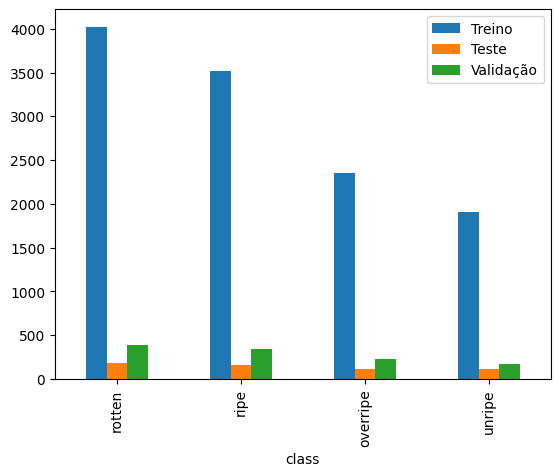

In [ ]:
pd.DataFrame({
    'Treino': train_df['class'].value_counts(),
    'Teste': test_df['class'].value_counts(),
    'Validação': val_df['class'].value_counts()
}).plot.bar()

Funções para extrair os dados e realizar pré-processamentos através de um ImageDataGenerator (onde é possível realizar outros processamentos aqui, como por exemplo, data augmentation), onde é realizado apenas a normalização dos bytes das imagens entre 0 e 1.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

Cria generators usando flow_from_dataframe a partir dos dados divididos em treino, val e teste.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    resample=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11793 validated image filenames belonging to 4 classes.
Found 1123 validated image filenames belonging to 4 classes.
Found 562 validated image filenames belonging to 4 classes.


### Visualização das imagens do primeiro batch do gerador de treinamento.

In [ ]:
images_view, labels_view = next(train_generator)

# Pega os índices correspondentes às imagens atuais
batch_indices = train_generator.index_array[:len(images_view)]

# Busca os caminhos no dataframe
image_paths = train_df.iloc[batch_indices]['filename'].values

Imagens originais do primeiro batch.

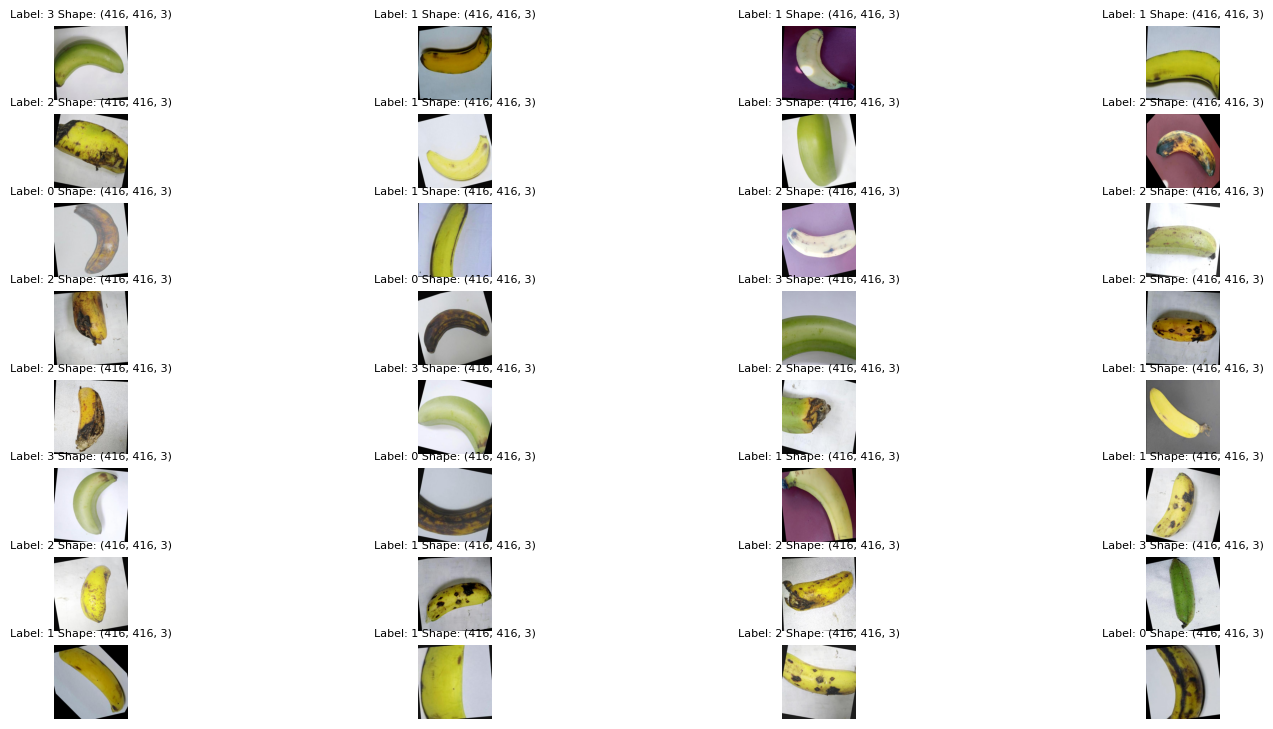

In [ ]:
plt.figure(figsize=(18,9))
for i in range(len(images_view)):
    plt.subplot(8, 4, i+1)
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Label: {labels_view[i].argmax()} Shape: {img.shape}", fontsize=8) # argmax adquire o maior valor do array (pois o label é categórico one-hot encoding)
    plt.axis('off')

Visualização das imagens processadas no primeiro batch.

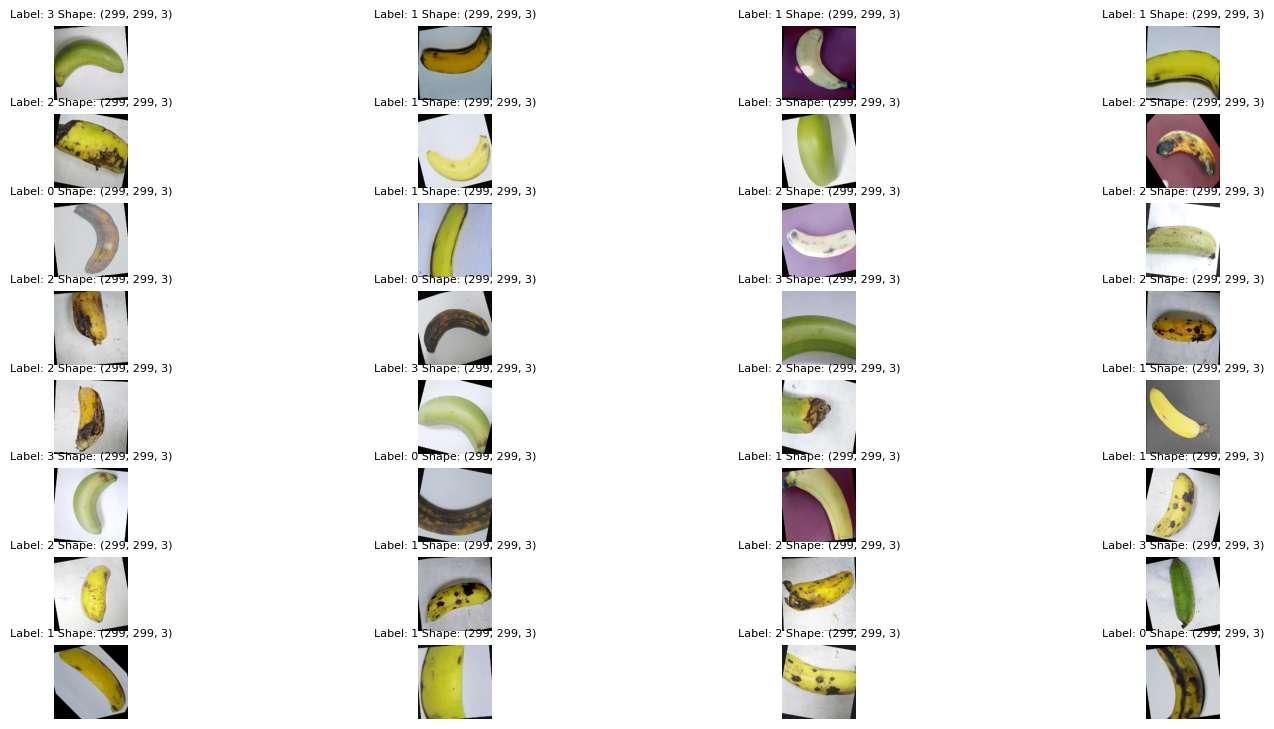

In [ ]:
plt.figure(figsize=(18,9))
for i in range(len(images_view)):
    plt.subplot(8, 4, i+1)
    plt.imshow(images_view[i])
    plt.title(f"Label: {labels_view[i].argmax()} Shape: {images_view[i].shape}", fontsize=8) # argmax adquire o maior valor do array (pois o label é categórico one-hot encoding)
    plt.axis('off')

### CNN treinada do zero

In [ ]:
raw_model = Sequential([
    Input(shape=(HEIGHT, WIDTH, 3)),

    Conv2D(32, (3,3), activation='relu'), # Adicionando camada convolucional com 32 filtros de 3x3 pixels
    MaxPooling2D(pool_size=(2,2)), # Reduz para metade da resolução

    Conv2D(64, (3,3), activation='relu'), # 64 filtros de 3x3 pixels
    MaxPooling2D(pool_size=(2,2)), # Reduz novamente

    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
raw_model.compile(optimizer=Adam(learning_rate=1e-4), # 0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
callbacks_raw_model = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='best_raw_model_{val_accuracy:.4f}.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

Em datasets desbalanceados, é interessante calcular pesos para cada classe (*class_weights*). Esta tecnica define **pesos maiores** para classes com **menos exemplos**, e **pesos menores** para classes com **mais exemplos**, assim, o **modelo dá mais atenção às classes minoritárias**.

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class'].values),
    y=train_df['class'].values
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.2551085568326947),
 1: np.float64(0.8370954003407155),
 2: np.float64(0.7333955223880597),
 3: np.float64(1.5500788643533123)}

In [ ]:
start_time = datetime.now()

history_raw_model = raw_model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks=callbacks_raw_model,
                    verbose=1,
                    class_weight=class_weights,
                    epochs=10)

end_time = datetime.now()

elapsed_time = end_time - start_time

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


369/369 ━━━━━━━━━━━━━━━━━━━━ 50s 119ms/step - accuracy: 0.6521 - loss: 0.8584 - val_accuracy: 0.8664 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.8593 - loss: 0.3517 - val_accuracy: 0.8923 - val_loss: 0.3191 - learning_rate: 1.0000e-04
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.8889 - loss: 0.2782 - val_accuracy: 0.9083 - val_loss: 0.2605 - learning_rate: 1.0000e-04
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.9199 - loss: 0.2154 - val_accuracy: 0.9012 - val_loss: 0.2728 - learning_rate: 1.0000e-04
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.9244 - loss: 0.1899 - val_accuracy: 0.9216 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.9407 - loss: 0.1572 - val_accuracy: 0.9163 - val_loss: 0.2426 - learning_rate: 1.0000e-04
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - acc

In [ ]:
print(f'Tempo de treinamento: {elapsed_time}')

Tempo de treinamento: 0:06:24.083945


Text(0, 0.5, 'Acurácia')

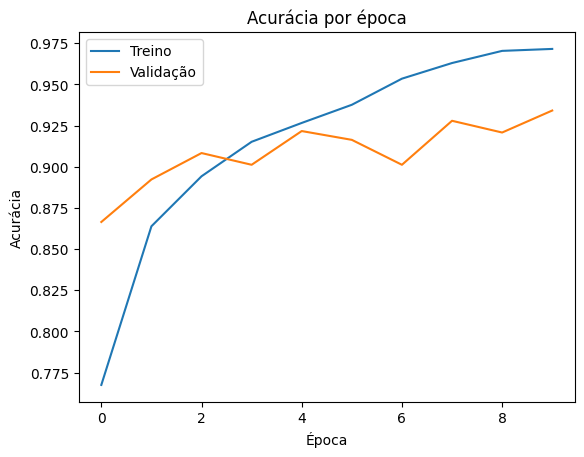

In [ ]:
plt.title("Acurácia por época")
plt.plot(history_raw_model.history['accuracy'])
plt.plot(history_raw_model.history['val_accuracy'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Perda')

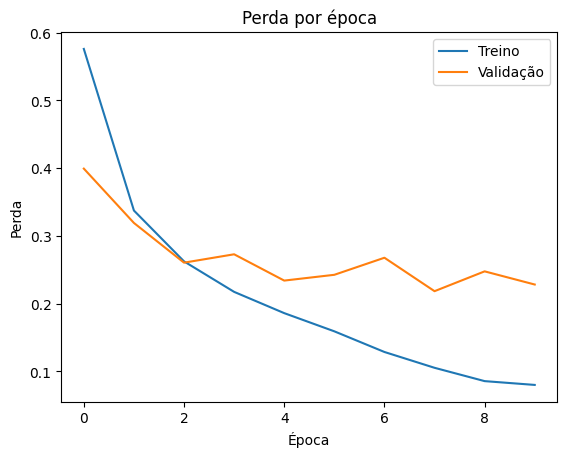

In [ ]:
plt.title("Perda por época")
plt.plot(history_raw_model.history['loss'])
plt.plot(history_raw_model.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Perda")

#### Avaliação do modelo

In [ ]:
predicts = raw_model.predict(test_generator, steps=len(test_generator), verbose=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


In [ ]:
predicted_classes = np.argmax(predicts, axis=1) # Converte as previsões (one-hot encoding) para rótulos de números inteiros
true_classes = test_generator.classes # Rótulos verdadeiros (int)

**Matriz de Confusão**

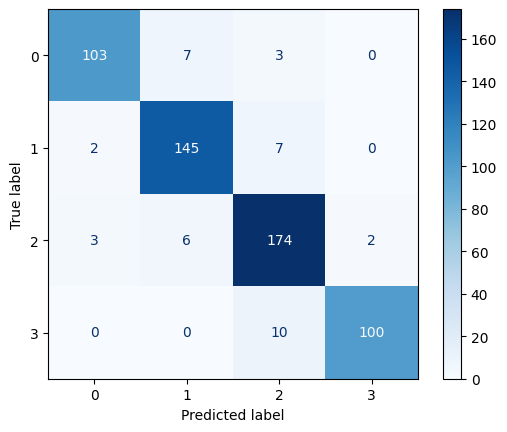

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(true_classes))
cm_display.plot(cmap='Blues')

**Métricas gerais com classification report**

In [ ]:
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       113
           1       0.92      0.94      0.93       154
           2       0.90      0.94      0.92       185
           3       0.98      0.91      0.94       110

    accuracy                           0.93       562
   macro avg       0.94      0.93      0.93       562
weighted avg       0.93      0.93      0.93       562



Binarização dos rótulos.

In [ ]:
n_classes = len(test_generator.class_indices)
y_true_binarized = label_binarize(test_generator.classes, classes=list(range(n_classes)))
y_true_binarized

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

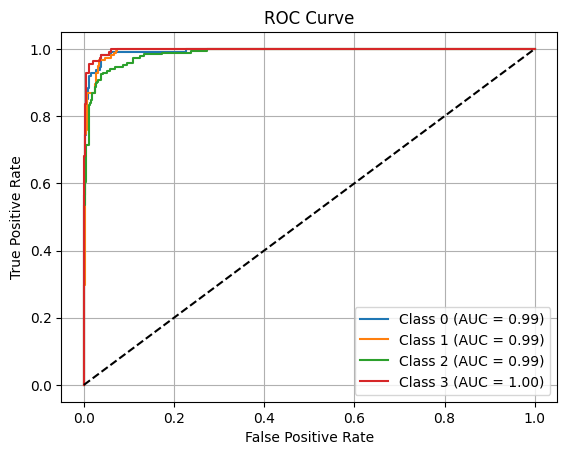

In [ ]:
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], predicts[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--') # Faz uma linha na diagonal, cortando o centro
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

### Transferência de Aprendizado

In [ ]:
base_model = InceptionV3(input_shape=(HEIGHT, WIDTH, 3),
                        include_top=False, # include_top=False já remove as camadas finais (de classificação) automaticamente
                        weights='imagenet')

base_model.trainable = False

Adicionando camadas de saída para o problema de classificação de bananas.

In [ ]:
input = Input(shape=(HEIGHT, WIDTH, 3))
x = base_model(input, training=False)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(len(labels_dataset), activation='softmax')(x)

model = tf.keras.Model(inputs=input,
                              outputs=pred)

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 299, 299, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 8, 8, 2048)    │ 21,802,784 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 131072)        │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │ 134,218,7… │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 156,025,636 (595.19 MB)

 Trainable params: 134,222,852 (512.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), # 0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='best_model_{val_accuracy:.4f}.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

In [ ]:
start_time = datetime.now()

history = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks=callbacks,
                    verbose=1,
                    class_weight=class_weights,
                    epochs=10)

end_time = datetime.now()

elapsed_time = end_time - start_time

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 85s 179ms/step - accuracy: 0.7953 - loss: 1.4163 - val_accuracy: 0.9377 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.9404 - loss: 0.1548 - val_accuracy: 0.9590 - val_loss: 0.1509 - learning_rate: 1.0000e-04
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.9558 - loss: 0.1181 - val_accuracy: 0.9635 - val_loss: 0.1181 - learning_rate: 1.0000e-04
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.9740 - loss: 0.0711 - val_accuracy: 0.9555 - val_loss: 0.1497 - learning_rate: 1.0000e-04
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.9827 - loss: 0.0460 - val_accuracy: 0.9546 - val_loss: 0.1566 - learning_rate: 1.0000e-04
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.9809 - loss: 0.0521 - val_accuracy: 0.9688 - val_loss: 0.1549 - learning_rate: 1.0000e-04
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/

In [ ]:
print(f'Tempo de treinamento: {elapsed_time}')

Tempo de treinamento: 0:05:36.473048


Text(0, 0.5, 'Acurácia')

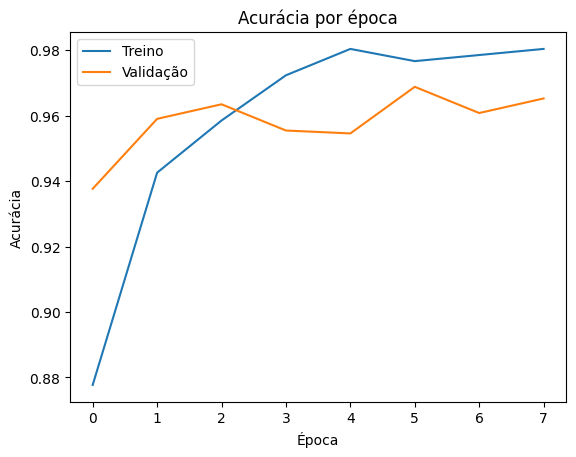

In [ ]:
plt.title("Acurácia por época")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Perda')

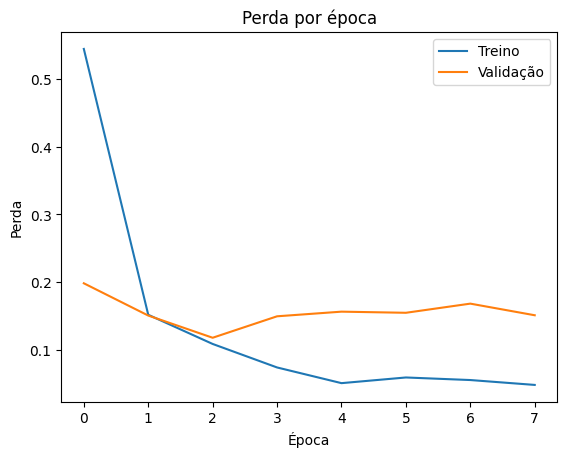

In [ ]:
plt.title("Perda por época")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Perda")

#### Avaliação do modelo

Porém, a partir de agora, para evitar repetição de código iremos criar uma função para testar o modelo, passando como parâmetro o próprio modelo para realização dos testes.

In [ ]:
def evaluate_model(model):
  predicts = model.predict(test_generator, steps=len(test_generator), verbose=1)

  predicted_classes = np.argmax(predicts, axis=1) # Converte as previsões (one-hot encoding) para rótulos de números inteiros
  true_classes = test_generator.classes # Rótulos verdadeiros (int)

  # Matriz de confusão
  cm = confusion_matrix(true_classes, predicted_classes)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(true_classes))

  # Métricas gerais com classification report
  class_report = classification_report(true_classes, predicted_classes)

  n_classes = len(test_generator.class_indices)
  y_true_binarized = label_binarize(test_generator.classes, classes=list(range(n_classes)))

  roc_auc_view = []

  for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], predicts[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_view.append({
        "plot": (fpr, tpr),
        "roc_auc": roc_auc
    })

  return cm_display, class_report, roc_auc_view


18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 700ms/step


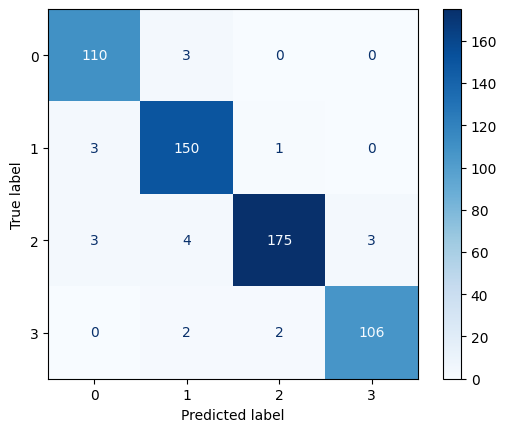

In [ ]:
cm, report, roc_auc_view = evaluate_model(model)
cm.plot(cmap='Blues')

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       113
           1       0.94      0.97      0.96       154
           2       0.98      0.95      0.96       185
           3       0.97      0.96      0.97       110

    accuracy                           0.96       562
   macro avg       0.96      0.96      0.96       562
weighted avg       0.96      0.96      0.96       562



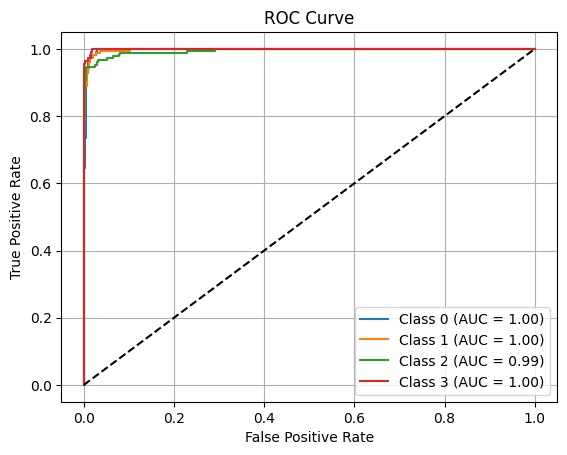

In [ ]:
for i in range(len(roc_auc_view)):
    fpr, tpr = roc_auc_view[i]['plot']
    roc_auc_value = roc_auc_view[i]['roc_auc']
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_value:.2f})')

plt.plot([0,1], [0,1], 'k--') # Faz uma linha na diagonal, cortando o centro
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

### Fine-Tuning

In [ ]:
fine_tuning_layers = 10

total_layers = len(base_model.layers)

# Mantem as camadas iniciais congeladas
for layer in base_model.layers[:total_layers - fine_tuning_layers]:
  layer.trainable = False

# Descongela as ultimas camadas do modelo
for layer in base_model.layers[total_layers - fine_tuning_layers:]:
  layer.trainable = True

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 299, 299, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 8, 8, 2048)    │ 21,802,784 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 131072)        │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │ 134,218,7… │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 4)             │      4,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 424,471,342 (1.58 GB)

 Trainable params: 134,223,044 (512.02 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

 Optimizer params: 268,445,706 (1.00 GB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-6), # 0.000001
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
callbacks_fine_tuning = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='best_model_fine_tuning_{val_accuracy:.4f}.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

In [ ]:
start_time = datetime.now()

history_2 = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks=callbacks_fine_tuning,
                    verbose=1,
                    class_weight=class_weights,
                    epochs=50)

end_time = datetime.now()

elapsed_time = end_time - start_time

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 75s 167ms/step - accuracy: 0.9889 - loss: 0.0297 - val_accuracy: 0.9644 - val_loss: 0.1267 - learning_rate: 1.0000e-06
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9882 - loss: 0.0283 - val_accuracy: 0.9653 - val_loss: 0.1264 - learning_rate: 1.0000e-06
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.9896 - loss: 0.0258 - val_accuracy: 0.9635 - val_loss: 0.1271 - learning_rate: 1.0000e-06
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.9901 - loss: 0.0289 - val_accuracy: 0.9653 - val_loss: 0.1264 - learning_rate: 1.0000e-06
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 44s 119ms/step - accuracy: 0.9907 - loss: 0.0204 - val_accuracy: 0.9679 - val_loss: 0.1259 - learning_rate: 1.0000e-06
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.9896 - loss: 0.0285 - val_accuracy: 0.9662 - val_loss: 0.1261 - learning_rate: 1.0000e-06
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms

In [ ]:
print(f'Tempo de treinamento: {elapsed_time}')

Tempo de treinamento: 0:16:17.799294


Text(0, 0.5, 'Acurácia')

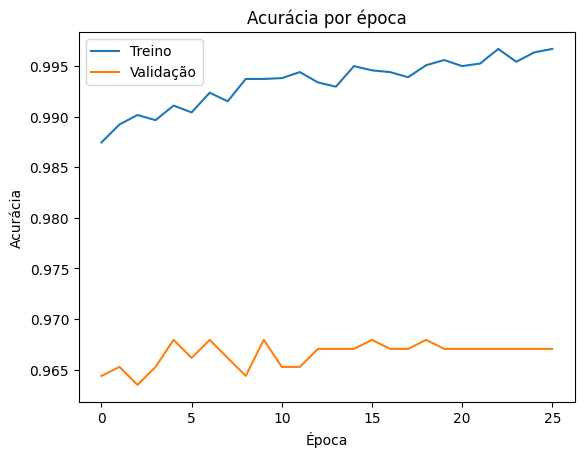

In [ ]:
plt.title("Acurácia por época")
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Perda')

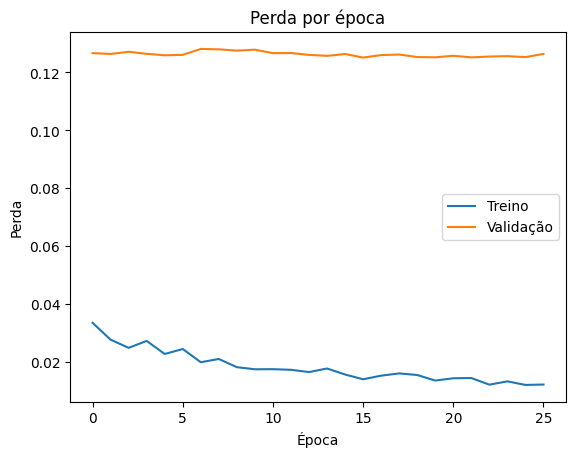

In [ ]:
plt.title("Perda por época")
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['Treino', 'Validação'])
plt.xlabel("Época")
plt.ylabel("Perda")

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 400ms/step


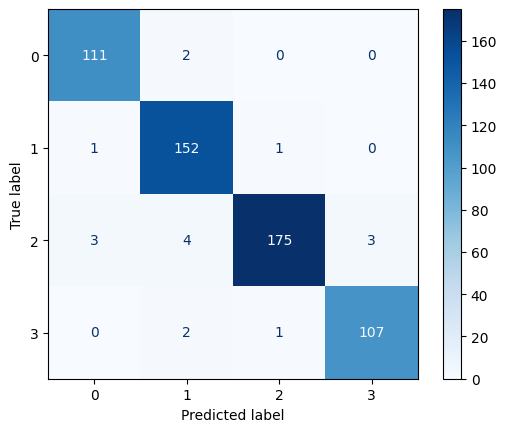

In [ ]:
cm, report, roc_auc_view = evaluate_model(model)
cm.plot(cmap='Blues')

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       113
           1       0.95      0.99      0.97       154
           2       0.99      0.95      0.97       185
           3       0.97      0.97      0.97       110

    accuracy                           0.97       562
   macro avg       0.97      0.97      0.97       562
weighted avg       0.97      0.97      0.97       562



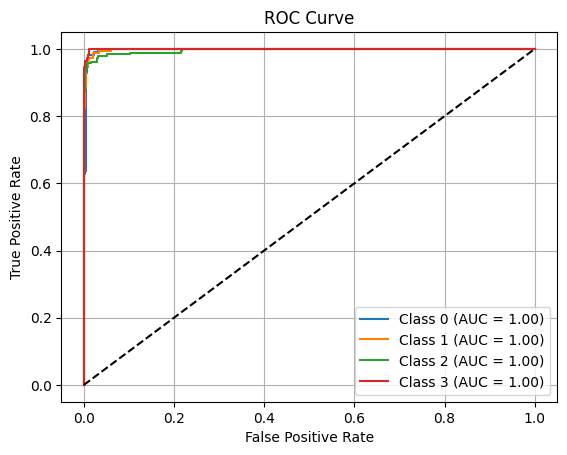

In [ ]:
for i in range(len(roc_auc_view)):
    fpr, tpr = roc_auc_view[i]['plot']
    roc_auc_value = roc_auc_view[i]['roc_auc']
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_value:.2f})')

plt.plot([0,1], [0,1], 'k--') # Faz uma linha na diagonal, cortando o centro
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

### Conclusão

#### CNN treinada do zero
- Melhor modelo: 92.79% de acurácia
- Tempo de treinamento: 6 minutos e 24 segundos

#### CNN com transferência de aprendizado (InceptionV3)
- Melhor modelo: 96.35% de acurácia
- Tempo de treinamento: 5 minutos e 36 segundos

#### CNN com ajuste fino (fine tuning) utilizando o InceptionV3 como base
- Melhor modelo: 96.79% de acurácia
- Tempo de treinamento: 16 minutos e 17 segundos

Não há muita diferença entre a performance dos 3 modelos, porém, o modelo CNN treinado do zero ficou abaixo da performance dos modelos com transferência de aprendizado e fine tuning. Os dois últimos tiveram performances quase idênticas, porém com a técnica de fine tuning foi possível adquirir um pequeno acréscimo de melhoria (+ 0.44% de acurácia).

É possível concluir que, para nosso caso, não seria tão necessário uma complexidade tão grande para o modelo convergir bem, pois apenas com o modelo CNN treinado do zero foi possível atingir uma métrica superior a 90%. Ainda assim, é interessante usar diferentes métodos para testar se é possível adquirir métricas ainda maiores. Porém, não é sempre que um modelo mais simples consegue convergir bem como no nosso caso, as vezes é necessário testar diferentes técnicas, como a transferência de aprendizagem ou fine tuning para adquirir métricas melhores, algo que apenas com um modelo simples não seria possível.

**Facilidade de uso/integração**

Considerando que esses modelos podem ser integrados em uma API para futuro uso, ambos os modelos tem o mesmo grau de complexidade para integração, pois ambos podem ser exportados com a extensão .keras e ser consumido em um endpoint. Porém a complexidade para construção desses modelos tem graus de complexidades diferentes. No caso, o modelo treinado do zero pode parecer mais simples de ser implementado, porém seria necessário ter conhecimento sobre como criar uma arquitetura de redes neurais convolucionais do zero. Pelo fato do modelo com transferência de aprendizado ser pré-treinado em um dataset grande como o ImageNet e já ter várias camadas convolucionais para extração de características, apenas seria necessário adicionar algumas camadas de saída para o problema específico desejado. Porém, ainda assim, para ambas implementações, é realmente necessário pelo menos um conhecimento básico sobre redes neurais convolucionais para implementação e integração.

**Tempo de treinamento**

Por mais que o modelo com transferência de aprendizado seja mais complexo e se saiu melhor que o modelo treinado do zero, o tempo de treinamento foi menor para este caso (mas pode ser também apenas uma coincidência). Podemos concluir que o tempo de treinamento para ambos não houve muita diferença, porém a diferença do tempo de treinamento do modelo com fine tuning foi grande, mas isso pelo fato de termos alterado a paciência para 10 e aumentado a quantidade de épocas, porém mesmo assim, não houve uma melhora significativa na performance.